## RNN

In [1]:

from __future__ import unicode_literals, print_function, division
from io import open
import glob # glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
import os

def findFiles(path): return glob.glob(path)

print(findFiles('./data/txtRnn/names/*.txt'))


['./data/txtRnn/names/Polish.txt', './data/txtRnn/names/Spanish.txt', './data/txtRnn/names/Japanese.txt', './data/txtRnn/names/Dutch.txt', './data/txtRnn/names/Scottish.txt', './data/txtRnn/names/French.txt', './data/txtRnn/names/English.txt', './data/txtRnn/names/Irish.txt', './data/txtRnn/names/Chinese.txt', './data/txtRnn/names/Korean.txt', './data/txtRnn/names/Vietnamese.txt', './data/txtRnn/names/Russian.txt', './data/txtRnn/names/Portuguese.txt', './data/txtRnn/names/Italian.txt', './data/txtRnn/names/German.txt', './data/txtRnn/names/Arabic.txt', './data/txtRnn/names/Czech.txt', './data/txtRnn/names/Greek.txt']


In [2]:

import unicodedata  # 모든 유니코드 문자에 대한 문자 속성을 정의하는 유니코드 문자 데이터베이스(UCD – Unicode Character Database)에 대한 액세스를 제공
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)  
        # 'NFD' (Normalization Form Canonical Decomposition) 정규화.
            # 문자를 기본 문자(base character)와 발음 구별 기호(combining diacritics)로 분리.
            # 예: 'é' (U+00E9) -> 'e' (U+0065) + '́' (U+0301)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
        #  unicodedata.category(c)는 주어진 유니코드 문자 'c'의 일반 카테고리를 반환.
            # 'Mn'은 "Mark, Nonspacing"의 약자로, 발음 구별 기호와 같이 다른 문자에 겹쳐서 표현되는 비간격 문자(non-spacing characters)를 나타냄.
            # 이 조건은 발음 구별 기호(예: 악센트, 움라우트 등)를 필터링하여 제거.
            # 예: 'é'가 'e'와 '́'로 분리되었을 때, '́'의 카테고리가 'Mn'이므로 이 조건에 의해 걸러짐.
    )

print(unicodeToAscii('Ślusàrski'))


Slusarski


In [3]:

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('./data/txtRnn/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [4]:
n_categories

18

In [5]:
# category_lines
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [6]:
# .. note::
#    역자 주: One-Hot 벡터는 언어 및 범주형 데이터를 다룰 때 주로 사용하며,
#    단어, 글자 등을 벡터로 표현할 때 단어, 글자 사이의 상관 관계를 미리 알 수 없을 경우,
#    One-Hot으로 표현하여 서로 직교한다고 가정하고 학습을 시작합니다.
#    이와 동일하게, 상관 관계를 알 수 없는 다른 데이터의 경우에도 One-Hot 벡터를 활용할 수 있습니다.
#

import torch

# all_letters 로 문자의 주소 찾기, 예시 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한 개의 문자를 <1 x n_letters> Tensor로 변환
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('o'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
class LSTM_case (nn.module):
    def __init__(self, input_size, hidden_size, output_size):
        super (LSTM_case, self)

        self.lstm_01 = nn.LSTM(input_size, hidden_size, num_layers=3)
        self.fn = nn.linear(hidden_size, output_size)

    def forward(self, x):
        


In [9]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [10]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8254, -2.8409, -2.9907, -2.8171, -2.9989, -2.8379, -2.9219, -3.0690,
         -2.8089, -2.8439, -2.9928, -2.9346, -2.9317, -2.8204, -2.9232, -2.9582,
         -2.7220, -2.8550]], grad_fn=<LogSoftmaxBackward0>)


In [11]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)  # 텐서의 가장 큰 값 및 주소
    category_i = top_i[0].item()   # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Czech', 16)


In [12]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Kalakos
category = Chinese / line = Wong
category = Portuguese / line = Moreno
category = Irish / line = Brady
category = Japanese / line = Sasaki
category = Arabic / line = Touma
category = German / line = Kerwer
category = Portuguese / line = Paredes
category = Arabic / line = Tuma
category = Arabic / line = Gerges


In [13]:
learning_rate = 0.005  # 학습률을 너무 높게 설정하면 발산할 수 있고, 너무 낮으면 학습이 되지 않을 수 있습니다.

criterion = nn.NLLLoss()

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [14]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # ``iter`` 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 23s) 2.3211 Riagan / Scottish ✗ (Irish)
10000 10% (0m 46s) 0.3433 Kyritsis / Greek ✓
15000 15% (1m 7s) 1.6357 O'Kelly / English ✗ (Irish)
20000 20% (1m 31s) 1.3113 Lee / Chinese ✗ (Korean)
25000 25% (1m 54s) 1.3808 O'Neal / Irish ✓
30000 30% (2m 13s) 0.8588 Slivka / Czech ✓
35000 35% (2m 31s) 1.6049 O'Hara / Japanese ✗ (Irish)
40000 40% (2m 51s) 2.2419 Pitcher / German ✗ (English)
45000 45% (3m 13s) 0.9260 Ra / Korean ✓
50000 50% (3m 36s) 0.3183 Tsahalis / Greek ✓
55000 55% (3m 58s) 0.0460 Garofalis / Greek ✓
60000 60% (4m 21s) 0.4746 Manos / Greek ✓
65000 65% (4m 43s) 6.6026 Mas / Chinese ✗ (Spanish)
70000 70% (5m 6s) 0.3870 Damhain / Irish ✓
75000 75% (5m 25s) 0.6178 Belo / Portuguese ✓
80000 80% (5m 47s) 0.1425 Deng / Chinese ✓
85000 85% (6m 8s) 0.5269 Aldana / Spanish ✓
90000 90% (6m 30s) 0.0211 Jaskulski / Polish ✓
95000 95% (6m 51s) 0.8006 Stoep / Dutch ✓
100000 100% (7m 13s) 0.3453 Brzezicki / Polish ✓


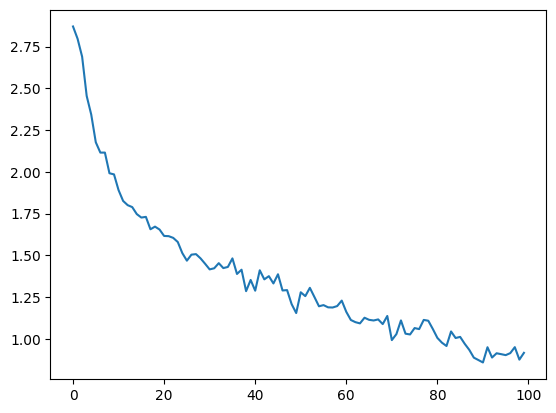

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_30308/2811754854.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_30308/2811754854.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


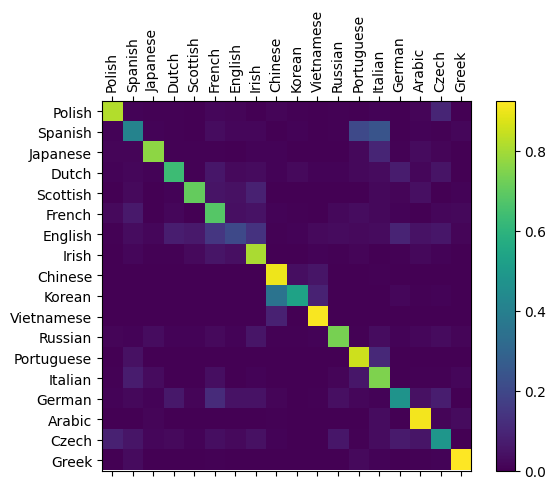

In [16]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 예시 중 어떤 것이 정확히 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [17]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.67) Russian
(-1.30) Czech
(-2.03) English

> Jackson
(-0.06) Scottish
(-3.47) English
(-4.75) German

> Satoshi
(-0.87) Japanese
(-1.25) Italian
(-2.08) Portuguese
